<span style="font-size: 120%">Limits the job postings dataset to those most similar to the user's resume allowing:</span>
 - <span style="font-size: 120%">faster k-means processing in the following notebook</span>
 - <span style="font-size: 120%">less individual jobs postings to sift through from the
   perspective of a job seeker</span>

<span style="font-size: 120%">However doing so will almost certainly change the sample
from a statistical point of view.<br>That is, make it less representative of the 
original population, and more representative of <br>a different population given the sample
was truncated non-arbitrarily.</span>

In [1]:
from sklearn.metrics.pairwise        import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline
from matplotlib import pyplot as plt
import numpy  as np
import pandas as pd

import PyPDF2 as pp2

import json


In [2]:
ngram_param = None
with open('config.json') as f:
    ngram_param = tuple(json.load(f)['ngram_range'])
ngram_param

(1, 1)

In [3]:
resume_dict = None
with open('data/Resume_Tek-Cub.pdf', 'rb') as f:
    page = pp2.PdfFileReader(f).getPage(0)
    resume_dict = {'title':['resume'], 'body':[page.extractText()], 'li_elems':['']}
    

In [4]:
jobs_df = pd.read_pickle('data/jobs_df.pkl', 'zip')
jobs_df.head()

,title,body,li_elems
3,Senior Data Scientist - Risk Mitigation - Jers...,Senior Data Scientist - Risk Mitigation - Jers...,"(3+ years of experience crafting, developing, ..."
9,"Director, Data Scientist, Natural Language Pro...","Director, Data Scientist, Natural Language Pro...","(Lead workshops, innovation sessions with clie..."
10,eCommerce Senior Data Scientist - United States,eCommerce Senior Data Scientist - United State...,(Build machine learning systems to understand ...
11,"Associate Scientist, Data Science - Irving, TX...","Associate Scientist, Data Science - Irving, TX...","(Research and development of new products., Pr..."
12,"Data Scientist - Seattle, WA","Data Scientist - Seattle, WA\nA Bachelor or Ma...",(A Bachelor or Masters Degree in a highly quan...


In [5]:
# complete the dataset by including the user's resume document 

dataset_df = pd.DataFrame(resume_dict).append(jobs_df)
print(dataset_df.shape)
dataset_df.head()

(493, 3)


,title,body,li_elems
0,resume,Tek Cub\nFAMILIAR TECH / CONCEPTS\nLanguages: ...,
3,Senior Data Scientist - Risk Mitigation - Jers...,Senior Data Scientist - Risk Mitigation - Jers...,"(3+ years of experience crafting, developing, ..."
9,"Director, Data Scientist, Natural Language Pro...","Director, Data Scientist, Natural Language Pro...","(Lead workshops, innovation sessions with clie..."
10,eCommerce Senior Data Scientist - United States,eCommerce Senior Data Scientist - United State...,(Build machine learning systems to understand ...
11,"Associate Scientist, Data Science - Irving, TX...","Associate Scientist, Data Science - Irving, TX...","(Research and development of new products., Pr..."


In [6]:
# begin using NLP techniques:
# - use tf-idf as embedding: transform resume and dataset into tf-idf vectors
# - use unigrams, bi-grams, ansd tri-grams
 
# use content of job posting webpages and resume as corpus to derive vocabulary

In [7]:
corpus = dataset_df['body']
vocab  = TfidfVectorizer(ngram_range=ngram_param, stop_words='english')
freq_matrix = vocab.fit_transform(corpus)

resume_vec = freq_matrix[0, :]
jobs_vec = freq_matrix[1:, :]

print(f"resume vector dimensions: {resume_vec.shape}")
print(f"jobs vector dimensions:   {jobs_vec.shape}")

resume vector dimensions: (1, 10035)
jobs vector dimensions:   (492, 10035)


In [8]:
# see how similar resume is to the rest of dataset
cos_sims = cosine_similarity(jobs_vec, resume_vec)
cos_sims.shape

(492, 1)

In [9]:
# check some elements for expected results
for i in range(4):
    print(cos_sims[i][0], end='    ');

0.05314223398462385    0.08922963828567279    0.046371434627420036    0.11043520680240497    

In [10]:
# match job postings with their respective similarities
jobs_df['cosine_similarity'] = cos_sims
sorted_jobs_df = jobs_df.sort_values(by='cosine_similarity', ascending=False)
sorted_jobs_df = sorted_jobs_df.reset_index(drop=True)
sorted_jobs_df

,title,body,li_elems,cosine_similarity
0,"Data Scientist - Chesterfield, MO","Data Scientist - Chesterfield, MO\nCompany Det...",(Take high-level project requirements and form...,0.127448
1,"Data Scientist - Chesterfield, MO 63017","Data Scientist - Chesterfield, MO 63017\nCompa...",(Take high-level project requirements and form...,0.127190
2,"Data Science Software Engineer - San Diego, CA...","Data Science Software Engineer - San Diego, CA...","(Organize, transform, and verify the integrity...",0.126004
3,"Data Scientist - San Francisco, CA","Data Scientist - San Francisco, CA\nJob Descri...",(Perform hands-on analysis of large volumes of...,0.119804
4,"Senior Data Scientist - San Francisco, CA","Senior Data Scientist - San Francisco, CA\nJob...",(Perform hands-on analysis of large volumes of...,0.119635
...,...,...,...,...
487,"Senior Data Scientist - San Francisco, CA 94111","Senior Data Scientist - San Francisco, CA 9411...",(Be a subject matter expert on all things rela...,0.030222
488,Post-doc: Dissemination/implementation and/or ...,Post-doc: Dissemination/implementation and/or ...,(),0.028809
489,"Data Scientist - West Lafayette, IN 47906","Data Scientist - West Lafayette, IN 47906\nDTN...","(Gain experience in all areas of data science,...",0.028500
490,Professor of Data Sciences and Operations (Ope...,Professor of Data Sciences and Operations (Ope...,(),0.019954


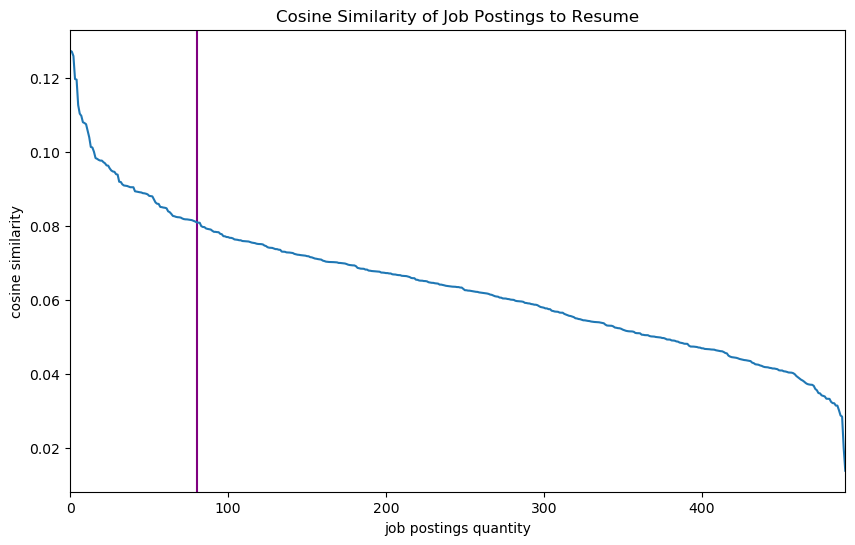

In [11]:
plt.figure(figsize=(10, 6))
plt.title('Cosine Similarity of Job Postings to Resume')
plt.xlabel('job postings quantity')
plt.ylabel('cosine similarity')
plt.axvline(x=80, color='purple')

sorted_jobs_df['cosine_similarity'].plot();

In [12]:
# intuiting from chart's slope: save the first 80 most similar job postings
pd.DataFrame(sorted_jobs_df[:80]).to_pickle('data/sorted_trunc_jobs_df.pkl', 'zip')